In [1]:
import numpy as np
import scipy.stats as st

import theano
import theano.tensor as tt

import matplotlib.pylab as plt
plt.style.use('seaborn-darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
theano.config.test_values = 'raise'

alpha = tt.dscalar("alpha")
beta = tt.dscalar("beta")
gamma = tt.dscalar("gamma")
delta = tt.dscalar("delta")
Z0 = tt.vector("Z0")
dt0 = tt.dscalar("dt")
steps = tt.iscalar("steps")


def rhs_ode(y, a, b, c, d, dt0):
    yprime = tt.zeros_like(y)
    yprime = tt.set_subtensor(
        yprime[0], y[0] + dt0 * (a * y[0] - b * y[0] * y[1]))
    yprime = tt.set_subtensor(
        yprime[1], y[1] + dt0 * (-c * y[1] + d * b * y[0] * y[1]))
    return yprime


# Symbolic loop through Euler updates
xout, updates = theano.scan(fn=rhs_ode,
                            outputs_info=Z0,
                            non_sequences=[alpha, beta, gamma, delta, dt0],
                            n_steps=steps)

simulation = theano.function(inputs=[Z0, alpha, beta, gamma, delta, dt0, steps],
                             outputs=xout,
                             updates=updates,
                             allow_input_downcast=True)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


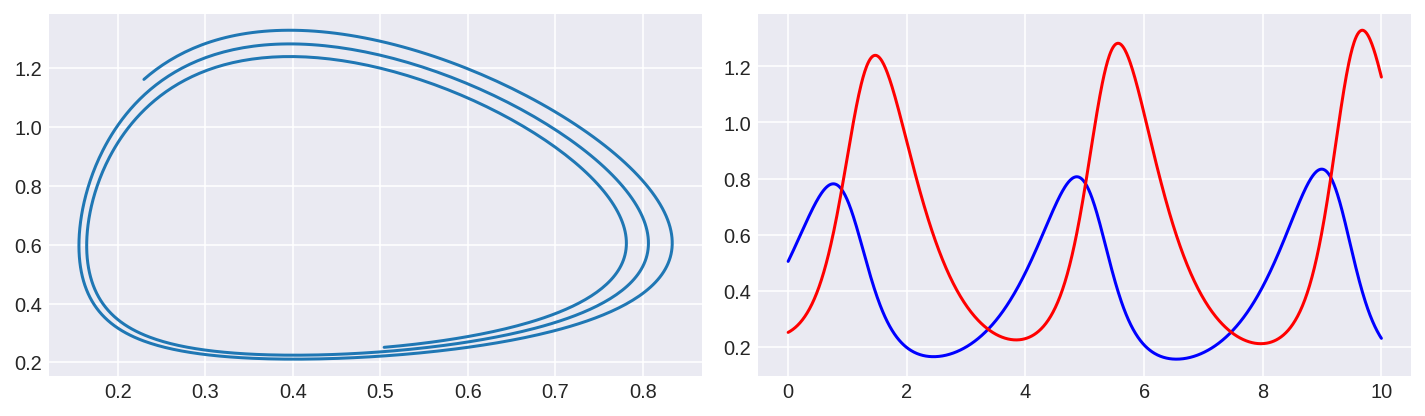

In [3]:
nstep = 1000
a, b, c, d, dt = 1.5, 2.5, 1.75, 1.75, .01
data = simulation(np.asarray([.5, 0.25]), a, b, c, d, dt, nstep)

_, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(data[:, 0], data[:, 1]);

# data_noise = data + np.random.randn(nstep, 2)*.05
# plt.plot(data_noise[:, 0], data_noise[:, 1]);

x = np.linspace(0, nstep*dt, nstep)
ax[1].plot(x, data[:, 0], 'b')
ax[1].plot(x, data[:, 1], 'r')

plt.tight_layout();

In [4]:
error = tt.square(xout - theano.shared(data)).sum()
db = theano.grad(error, [Z0, alpha, beta, gamma, delta, dt0])

In [5]:
grad_f = theano.function([Z0, alpha, beta, gamma, delta, dt0, steps], db)

In [6]:
grad_f(np.asarray([.5, 0.25])+.1, a+.1, b+.2, c-.001, d, dt, nstep)

[array([517.57336569, 711.82162211]),
 array(672.1992674),
 array(175.00520785),
 array(610.07805449),
 array(184.17456779),
 array(261505.94063291)]

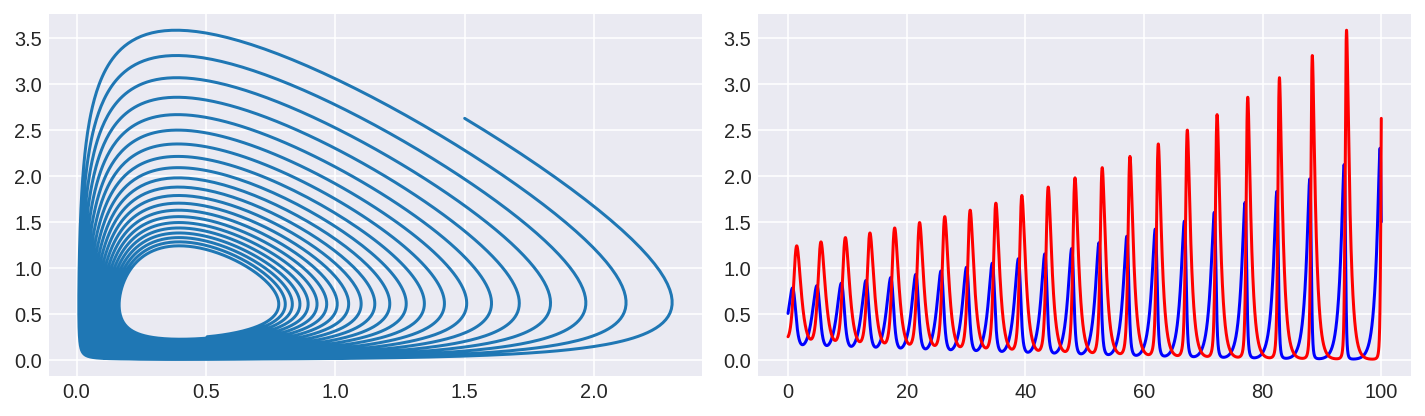

In [7]:
nstep = 10000
a, b, c, d, dt = 1.5, 2.5, 1.75, 1.75, .01
data = simulation(np.asarray([.5, 0.25]), a, b, c, d, dt, nstep)

_, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(data[:, 0], data[:, 1]);

# data_noise = data + np.random.randn(nstep, 2)*.05
# plt.plot(data_noise[:, 0], data_noise[:, 1]);

x = np.linspace(0, nstep*dt, nstep)
ax[1].plot(x, data[:, 0], 'b')
ax[1].plot(x, data[:, 1], 'r')

plt.tight_layout();

In [8]:
import scipy.integrate as spint

In [30]:
def lotkavolterra(y0, t, a, b, c, d):
    x, y = y0
    dydt = [a*x - b*x*y, -c*y + d*b*x*y]
    return dydt

y0 = [.5, .25]
t = np.linspace(0, nstep*dt, nstep)

In [31]:
%%time
data = spint.odeint(lotkavolterra, y0, t, args=(a, b, c, d))

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10.4 ms


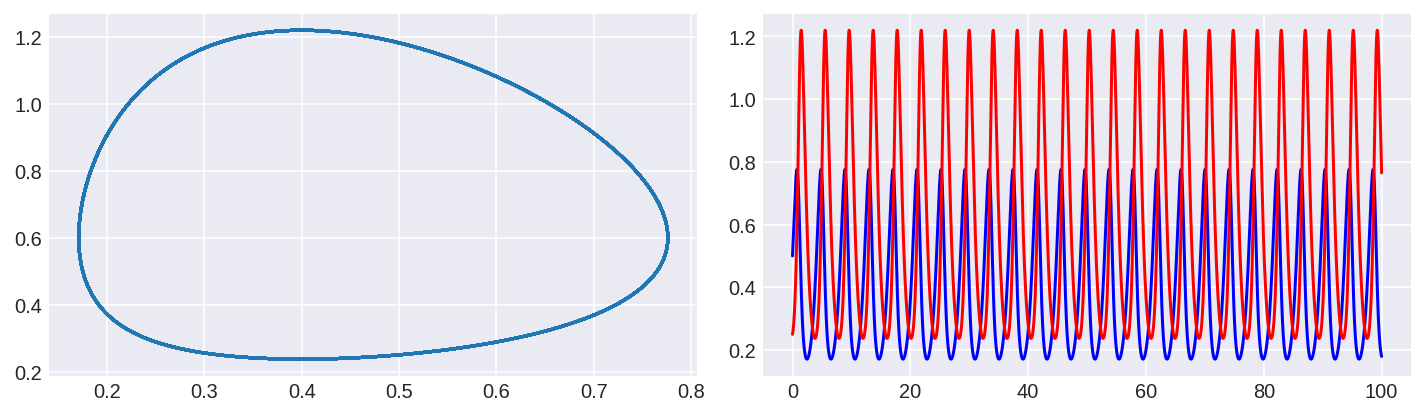

In [32]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(data[:, 0], data[:, 1]);

# data_noise = data + np.random.randn(nstep, 2)*.05
# plt.plot(data_noise[:, 0], data_noise[:, 1]);

x = t
ax[1].plot(x, data[:, 0], 'b')
ax[1].plot(x, data[:, 1], 'r')

plt.tight_layout();

In [33]:
def lotkavolterra2(t, y0):
    x, y = y0
    dydt = [a*x - b*x*y, -c*y + d*b*x*y]
    return dydt

In [34]:
%%time
sol = spint.solve_ivp(lotkavolterra2, (0, nstep*dt), y0, method='LSODA', dense_output=True)
data = sol.y.T

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 34.9 ms


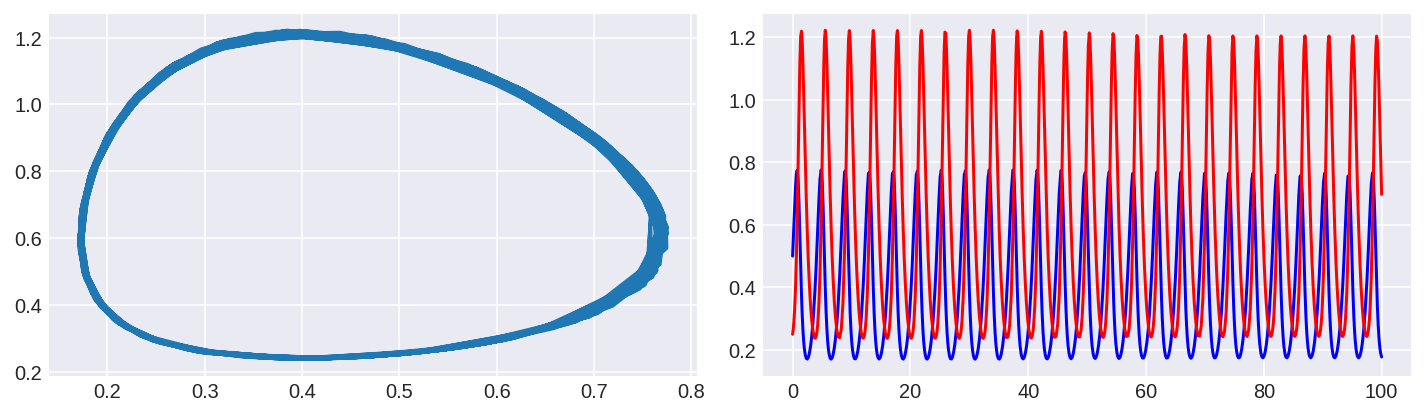

In [35]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(data[:, 0], data[:, 1]);

# data_noise = data + np.random.randn(nstep, 2)*.05
# plt.plot(data_noise[:, 0], data_noise[:, 1]);

x = sol.t
ax[1].plot(x, data[:, 0], 'b')
ax[1].plot(x, data[:, 1], 'r')

plt.tight_layout();